In [1]:
import sys, os, copy, time
import random
import numpy as np
import torch
HOME_PATH = os.path.expanduser('~')

import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import poisevae
from poisevae.datasets import MNIST_MNIST
from poisevae.networks.vanilla_MNIST import EncMNIST, DecMNIST

In [2]:
MNIST_PATH = os.path.join(HOME_PATH, 'Datasets/MNIST/%s.pt')

joint_dataset_train = MNIST_MNIST(mnist_pt_path=MNIST_PATH % 'train')
joint_dataset_test = MNIST_MNIST(mnist_pt_path=MNIST_PATH % 'test')

In [3]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(joint_dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(joint_dataset_test, batch_size=batch_size, shuffle=True, drop_last=True)
len(train_loader), len(test_loader)

(468, 78)

In [4]:
lat1, lat2 = 20, 20
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

enc_mnist1 = EncMNIST(lat1).to(device)
dec_mnist1 = DecMNIST(lat1).to(device)
enc_mnist2 = EncMNIST(lat1).to(device)
dec_mnist2 = DecMNIST(lat2).to(device)

# Options: 'derivative_autograd', 'derivative_gradient', and 'std_normal'
vae = poisevae.POISEVAE([enc_mnist1, enc_mnist2], [dec_mnist1, dec_mnist2], latent_dims=[lat1, (lat2)], 
                        enc_config='nu', KL_calc='std_normal', batch_size=batch_size
                       ).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
writer = None

cuda


In [5]:
epoch = 0

In [6]:
epochs = 3 + epoch
for epoch in tqdm(range(epoch, epochs)):
    poisevae.utils.train(vae, train_loader, optimizer, epoch, kl_weight=1, n_gibbs_iter=5, writer=writer)
    poisevae.utils.test(vae, test_loader, epoch, kl_weight=1, n_gibbs_iter=5, writer=writer)
    # if (epoch+1) % 10 == 0 and epoch > 0:
    #     poisevae.utils.save_checkpoint(vae, optimizer, os.path.join(PATH, 'training_%d.pt' % (epoch+1)), epoch+1) 

100%|███████████████████████████████████████████████████████████████████████████| 3/3 [00:29<00:00,  9.76s/it]


## Reconstruction

In [7]:
with torch.no_grad():
    for i, data in enumerate(test_loader):
        results = vae([data[0].to(device, dtype=torch.float32), data[0].to(device, dtype=torch.float32)])
        break

results['x_rec'][0].shape

torch.Size([128, 784])

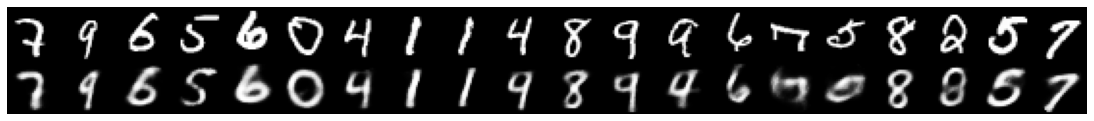

In [8]:
ncols = min(len(results['x_rec'][0]), 20)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 1.5))
for i, aux in enumerate(zip(data[0], results['x_rec'][0])):
    if i >= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.cpu().numpy().reshape(28, 28), cmap='gray')
        ax[j, i].set_axis_off()
# ax[1, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
# fig.savefig(PATH + 'MNISTRec.pdf', dpi=300)

## Cross Generation

In [13]:
with torch.no_grad():
    for i, data in enumerate(test_loader):
        results = vae([data[0].to(device, dtype=torch.float32), None])
        break

results['x_rec'][0].shape

torch.Size([128, 784])

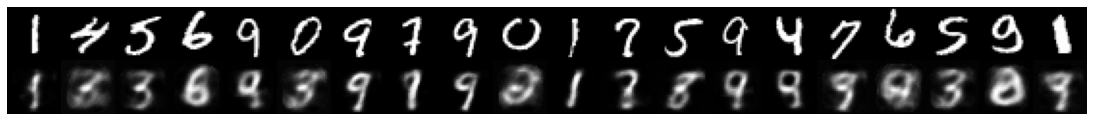

In [16]:
miss_index = 1
ncols = min(len(results['x_rec'][miss_index]), 20)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 1.5))
for i, aux in enumerate(zip(data[0], results['x_rec'][miss_index])):
    if i >= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.cpu().numpy().reshape(28, 28), cmap='gray')
        ax[j, i].set_axis_off()
# ax[1, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
# fig.savefig(PATH + 'MNISTRec.pdf', dpi=300)

## Joint Generation

In [11]:
with torch.no_grad():
    results = vae.generate(n_samples=12)
results['x_rec'][0].shape

torch.Size([12, 784])

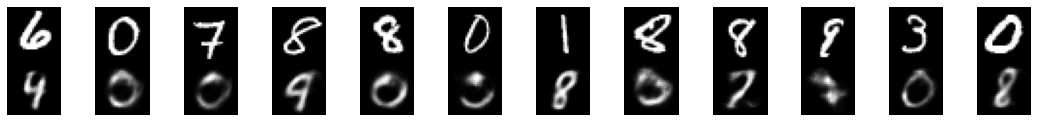

In [12]:
ncols = min(len(results['x_rec'][0]), 20)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 1.5))
for i, aux in enumerate(zip(data[0], results['x_rec'][0])):
    if i >= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.cpu().numpy().reshape(28, 28), cmap='gray')
        ax[j, i].set_axis_off()
# ax[1, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
# fig.savefig(PATH + 'MNISTRec.pdf', dpi=300)